In [10]:
import EmbeddedCV
import cv2
import numpy as np
import os
from scipy.ndimage import convolve
from matplotlib import pyplot as plt
from matplotlib import rcParams

rcParams["figure.figsize"] = 14 ,7

# Test verifiers

In [11]:
import numpy as np

def check_correctness(path, y_pred, y):
    diff = y_pred.astype(np.int32) - y.astype(np.int32)
    abs_diff = np.abs(diff)
    max_diff = np.max(abs_diff)
    avg_diff = np.mean(abs_diff)

    if y_pred.shape[2] == 1:
        gray = True
    else: 
        gray = False

    cv2.imwrite(path + "pred.png", y_pred.astype(np.uint8))
    cv2.imwrite(path + "true.png", y.astype(np.uint8))
    cv2.imwrite(path + "diff.png", abs_diff.astype(np.uint8))

    fig, ax = plt.subplots(1,2)
    ax[0].axis("off")
    ax[1].axis("off")

    ax[0].set_title("Image processing pipeline")
    ax[1].set_title("Naive implementation")
    
    ax[0].imshow(cv2.cvtColor(y_pred, cv2.COLOR_BGR2RGB))
    ax[1].imshow(cv2.cvtColor(y, cv2.COLOR_BGR2RGB))

    print("Max diff:", max_diff)
    print("Avg diff:", avg_diff)
    print(sum(abs_diff.sum(axis=2).flatten() > 3))

    return True

In [12]:
from functions import gaussian_blur, median_blur, min_max_normalize
from generator import gen_image

# Tests

Setup

In [13]:
device = False
snapshot = True
devicePath = "/dev/video0"

qualititative_tests = True

In [14]:
host = EmbeddedCV.Host()

if device:
    channels = 3
    rows = 360
    cols = 640
    snapshot = True
    cam = EmbeddedCV.CameraHS(devicePath, snapshot, channels, rows, cols)
else:
    channels = 3
    rows = 576
    cols = 768
    cam = EmbeddedCV.CameraSim(snapshot, channels, rows, cols)

host.Configure(cam)

Qualitative tests

In [15]:
functions = ["median_blur", "gaussian_blur", "sobel", "canny_edge"]
function_type = functions[2]

In [16]:
if device:
    image = np.zeros(shape=(channels*rows*cols), dtype=np.uint8)
    host.Sanity(image)
    image = image.reshape((rows, cols, channels))
else:
    image_path = "qualititative/qualititative.png"
    image = cv2.imread(image_path)

    flat_image = image.flatten()

    cam.StoreData(flat_image)

Max diff: 121
Avg diff: 0.11631416980131173
948


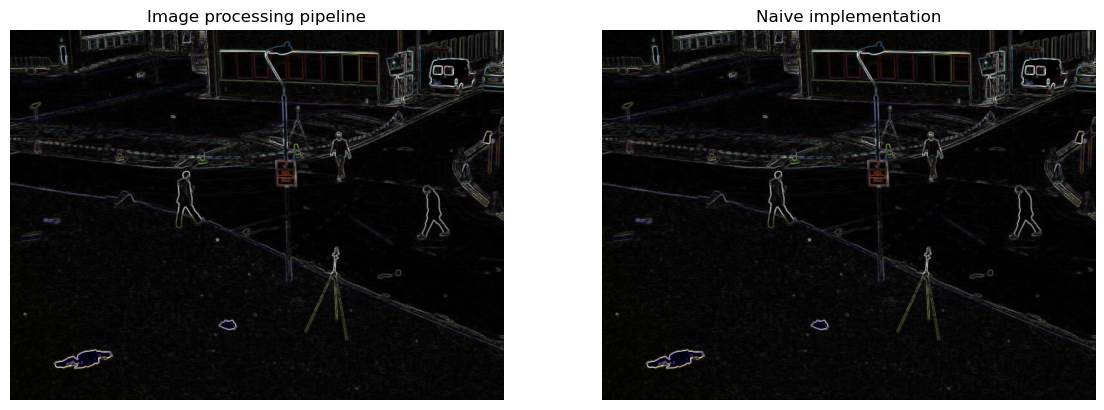

In [17]:
match function_type:
    case "median_blur":
        kernel_height, kernel_width = 3, 3
        
        host_output = np.zeros(shape=(channels*rows*cols), dtype=np.uint16)
        host.MedianBlur(host_output, kernel_height, kernel_width)
        host_output = host_output.reshape((rows, cols, channels))
        
        naive_output = median_blur(image, kernel_height, kernel_width)
        
        check_correctness("qualititative/median_blur/",
                          y_pred=min_max_normalize(host_output), 
                          y=min_max_normalize(naive_output))
    case "gaussian_blur":
        kernel_height, kernel_width = 5, 5
        sigma_x, sigma_y = 1, 1
        
        host_output = np.zeros(shape=(channels*rows*cols), dtype=np.uint8)
        host.GaussianBlur(host_output, 
                          kernel_height, kernel_width, 
                          sigma_x, sigma_y)
        host_output = host_output.reshape((rows, cols, channels))
        
        naive_output = gaussian_blur(image, kernel_height, kernel_width, sigma_x, sigma_y)
        
        check_correctness("qualititative/gaussian_blur/", y_pred=host_output, y=naive_output)
    case "sobel":
        host_output = np.zeros(shape=(channels*rows*cols), dtype=np.uint16)
        host.Sobel(host_output)
        host_output = host_output.reshape((rows, cols, channels))

        x = cv2.Sobel(image.astype(np.uint16),
                      cv2.CV_64F, 1, 0, 3)
        y = cv2.Sobel(image.astype(np.uint16),
                      cv2.CV_64F, 0, 1, 3)
        
        naive_output = np.sqrt(x**2 + y**2)

        check_correctness("qualititative/sobel/",
                          y_pred=min_max_normalize(host_output), 
                          y=min_max_normalize(naive_output))
    case "canny_edge":
        lowThreshold = 40
        highThreshold = 60
        
        host_output = np.zeros(shape=(1*rows*cols), dtype=np.uint8)
        host.CannyEdge(host_output, lowThreshold, highThreshold)
        host_output = host_output.reshape((rows, cols, 1))
        
        # the thresholds are approxiamtely inverse min-max normalized wrt. gradient magnitudes
        naive_output = cv2.Canny(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY),
                                 lowThreshold*3, highThreshold*3).reshape((rows, cols, 1))
        
        check_correctness("qualititative/canny_edge/", y_pred=host_output, y=naive_output)
    

Quantitative tests